In [1]:
import random

# Numpy
import numpy as np

# PyTorch
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.mobile_optimizer import optimize_for_mobile
import torchvision

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
import matplotlib.pyplot as plt
from PIL import Image

torch.__version__

'1.7.1'

In [2]:
torch.manual_seed(0)

tfms = torchvision.transforms.Compose([
  torchvision.transforms.RandomRotation(10.0),
  torchvision.transforms.RandomResizedCrop([32, 32], (0.9, 1.0)),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

val_tfms = torchvision.transforms.Compose([
      torchvision.transforms.RandomResizedCrop([32, 32], (1.0, 1.0)),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = torchvision.datasets.ImageFolder("/home/eg4l/datasets/data", loader=Image.open, transform=tfms)

print(f"Total length of dataset: {len(dataset)}")
train_size = int(len(dataset) * 0.9)
valid_size = len(dataset) - train_size

dataset_train, dataset_val = random_split(dataset, [train_size, valid_size])
print(f"Total length of train dataset: {len(dataset_train)}")
print(f"Total length of valid dataset: {len(dataset_val)}")

print(f"Classes: {dataset.classes}")

Total length of dataset: 1337
Total length of train dataset: 1203
Total length of valid dataset: 134
Classes: ['black', 'empty', 'white']


In [3]:
class ActualModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.quant = torch.quantization.QuantStub()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3).to(torch.float),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.25),
            nn.Conv2d(32, 128, kernel_size=3).to(torch.float),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((3, 3)),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, kernel_size=3).to(torch.float),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Flatten(),
        )

        self.fc = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 3),
        )

        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        # x = self.quant(x)
        x = self.conv(x)
        x = self.fc(x)
        # x = self.dequant(x)
        return x

class OurSmallModel(pl.LightningModule):

    def __init__(self, learning_rate=0.0003):
        super().__init__()

        self.learning_rate = learning_rate

        self.model = ActualModel()

    def forward(self, x):
        x = self.model(x)
        return x

    # to funkcja która wykona się przy każdym kroku w treningu
    def training_step(self, batch, batch_idx):
        # x: co wkładamy do modelu
        # y: odpowiedź której od modelu oczekujemy
        x, y = batch

        # przepuszczenie danych przez model
        prediction = self(x)
        prediction = torch.softmax(prediction, 1)


        # obliczenie lossa
        loss = F.mse_loss(prediction, F.one_hot(y, num_classes=3).float())
        return loss

    # to funkcja która wykona się przy każdym kroku w walidacji
    def validation_step(self, batch, batch_idx):
      x, y = batch

      # przepuszczenie danych przez model
      prediction = self(x)
      prediction = torch.softmax(prediction, 1)

      # obliczenie lossa
      loss = F.mse_loss(prediction, F.one_hot(y, num_classes=3).float())

      predicted_number = torch.argmax(prediction, dim=1)
      # policzenie "celności" modelu
      prediction_accuracy = accuracy(prediction, y)

      # wypisanie naszych statystyk walidacyjnych
      self.log('val_loss', loss, prog_bar=True)
      self.log('val_acc', prediction_accuracy, prog_bar=True)

      return loss

    # W tej fukcji definiujemy sobie optimizer
    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      return optimizer

    # W tej funkcji definiujemy dataloader do treningu
    def train_dataloader(self):
      return DataLoader(dataset_train, batch_size=16, num_workers=8)

    # W tej funkcji definiujemy dataloader do walidacji
    def val_dataloader(self):
      return DataLoader(dataset_val, batch_size=16, num_workers=8)

In [4]:
torch.manual_seed(0)

model = OurSmallModel()
# Zwrócmy uwagę na różnicę w prędkości między gpu=1, a gpu=0!
trainer = pl.Trainer(max_epochs=10, progress_bar_refresh_rate=1, gpus=1)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | ActualModel | 596 K 


Epoch 0:  89%|████████▉ | 76/85 [00:00<00:00, 104.75it/s, loss=0.045, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 1:  89%|████████▉ | 76/85 [00:00<00:00, 89.47it/s, loss=0.027, v_num=48, val_loss=0.0462, val_acc=0.903]
Validating: 0it [00:00, ?it/s]
Epoch 2:  89%|████████▉ | 76/85 [00:00<00:00, 113.06it/s, loss=0.022, v_num=48, val_loss=0.0385, val_acc=0.94]
Validating: 0it [00:00, ?it/s]
Epoch 3:  89%|████████▉ | 76/85 [00:00<00:00, 113.03it/s, loss=0.019, v_num=48, val_loss=0.0304, val_acc=0.948]
Validating: 0it [00:00, ?it/s]
Epoch 4:  89%|████████▉ | 76/85 [00:00<00:00, 115.97it/s, loss=0.013, v_num=48, val_loss=0.0244, val_acc=0.97]
Validating: 0it [00:00, ?it/s]
Epoch 5:  89%|████████▉ | 76/85 [00:00<00:00, 116.43it/s, loss=0.010, v_num=48, val_loss=0.0214, val_acc=0.97]
Validating: 0it [00:00, ?it/s]
Epoch 6:  89%|████████▉ | 76/85 [00:00<00:00, 117.55it/s, loss=0.011, v_num=48, val_loss=0.0163, val_acc=0.97]
Validating: 0it [00:00, ?it/s]
Epoch 7:  89%|████████▉ | 76/85 [00:

1

In [5]:
def plot_images(images, columns, rows, figsize=(20, 15), labels=None):
    fig = plt.figure(figsize=figsize)

    ax = []

    for i in range(columns*rows):
        ax.append(fig.add_subplot(rows, columns, i+1))

        img = images[i]

        if labels is not None:
            label = labels[i]
            # if isinstance(label, torch.Tensor):
            #     label = dataset.classes[label.item()]
            ax[-1].set_title(label)

        plt.imshow(img, cmap='gray')

    plt.show()  # finally, render the plot


In [6]:
model = model.model
model = model.cpu()
model.eval()

model.qconfig = torch.quantization.get_default_qconfig('qnnpack')
torch.quantization.prepare(model, inplace=True)

ActualModel(
  (quant): QuantStub(
    (activation_post_process): HistogramObserver()
  )
  (conv): Sequential(
    (0): Conv2d(
      3, 32, kernel_size=(3, 3), stride=(1, 1)
      (activation_post_process): HistogramObserver()
    )
    (1): ReLU(
      inplace=True
      (activation_post_process): HistogramObserver()
    )
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(
      32, 128, kernel_size=(3, 3), stride=(1, 1)
      (activation_post_process): HistogramObserver()
    )
    (5): ReLU(
      inplace=True
      (activation_post_process): HistogramObserver()
    )
    (6): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(
      128, 256, kernel_size=(3, 3), stride=(1, 1)
      (activation_post_process): HistogramObserver()
    )
    (9): ReLU(
      inplace=True
      (activation_post_pro

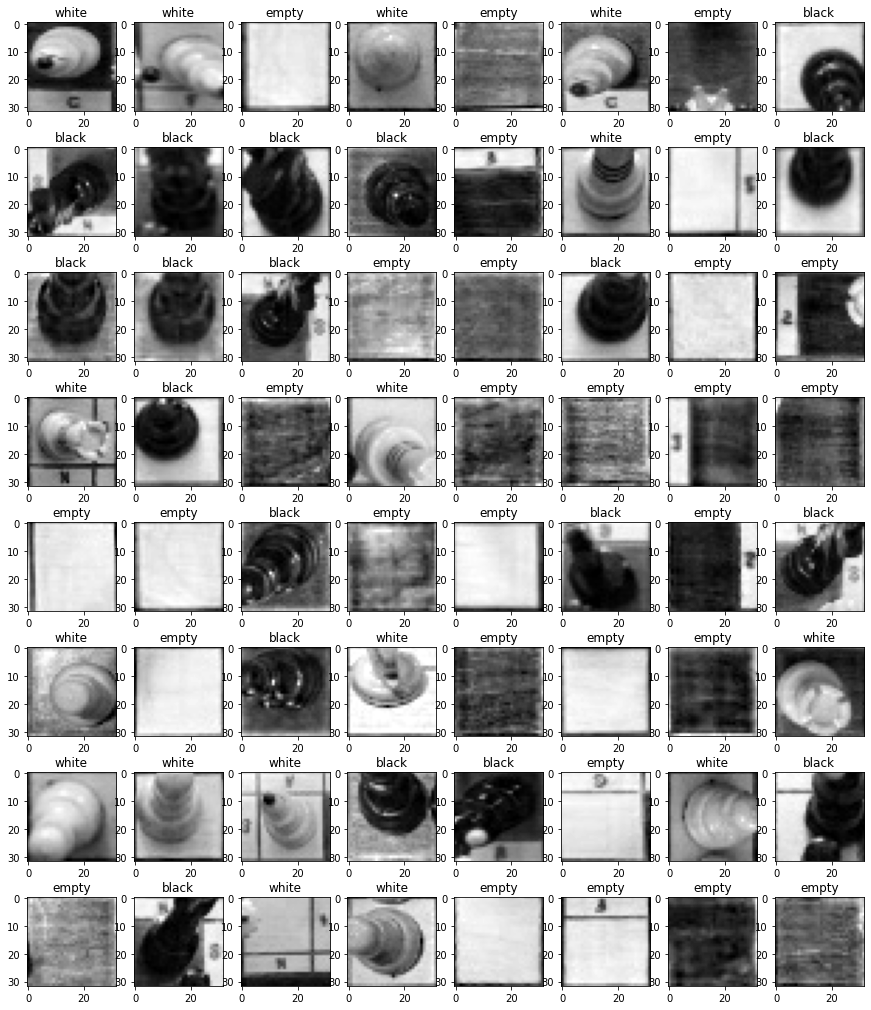

torch.Size([1, 3, 32, 32])

In [7]:
# calibration

transformed_images = []
labels = []
# for i in range(8):
#     labels.append(['' for i in range(8)])

# przerzucamy model w tryb ewaluacji

images = sorted(dataset.imgs, key=lambda x: random.random())[:64]
images = [x[0] for x in images]
images = [Image.open(x) for x in images]


for index, number in enumerate(images):
    number = val_tfms(number)
    x = number.unsqueeze(0)

    prediction = model(x)
    label = dataset.classes[torch.argmax(prediction, dim=1).item()]

    transformed_images.append(x[0][0].squeeze())
    labels.append(str(label))
    # predictions[index//8, index%8] = label

plot_images(transformed_images, 8, 8, labels=labels, figsize=(15,18))

x.shape

In [8]:
# torch.quantization.convert(model, inplace=True)

In [9]:
torchscript_model = torch.jit.script(model)

In [10]:
torchscript_model_optimized = optimize_for_mobile(torchscript_model)
# torchscript_model_optimized = torchscript_model

In [11]:
torch.jit.save(torchscript_model_optimized, '/home/eg4l/datasets/models/arm_model.pt')

In [12]:
print('done')
torch.__version__

done


'1.7.1'

In [13]:
test_img_path = '/home/eg4l/chessboardanalysis/app/src/main/assets/sample_cell2.jpg'
test_img = Image.open(test_img_path)
tensor = val_tfms(test_img).unsqueeze(0)
model(tensor)

tensor([[-1.9035, -0.7405,  2.9464]], grad_fn=<AddmmBackward>)